# Artykuł bazowy

[Granulated deep learning and Z-numbers in motion detection and object recognition](https://link.springer.com/article/10.1007/s00521-019-04200-1)

W artykule poruszono problematykę detekcji ruchu, rozpoznawania obiektów i opisu scen z wykorzystaniem głębokiego uczenia się w kontekście obliczeń granularnych. Ponieważ głębokie uczenie jest wymagające obliczeniowo, autorzy proponują zastosowanie obliczeń granularnych w celu zredukowania wymagań obliczeniowych.

In [1]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2
import math
from PIL import Image, ImageDraw
import platform
from time import time
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

2024-05-24 12:08:36.198006: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 12:08:36.612433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 12:08:36.615715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 12:08:38.702537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Python version: 3.8.0
Tensorflow version: 2.12.0
Keras version: 2.12.0


# Ładowanie modelu SSD

Nasze prace rozpoczęliśmy od załadowania modelu SSD, który jest wykorzystywany do detekcji obiektów,
oraz zdefiniowania funkcji pomocniczych do przetwarzania obrazów.

Ten etap sfinalizowaliśmy przetestoaniem modelu na przykładowym obrazie.

In [2]:
WINDOW_SIZE = 10
MODEL_NAME = 'ssdlite_mobilenet_v2_coco_2018_05_09'
LABELS_NAME = 'mscoco_label_map.pbtxt'
TEST_IMAGES_DIR_PATH = pathlib.Path('data')
TEST_IMAGE_PATHS = sorted(list(TEST_IMAGES_DIR_PATH.glob('*.jpg')))
TEST_IMAGE_PATHS

[PosixPath('data/elephant.jpg'),
 PosixPath('data/quad-of-four-colors.jpg'),
 PosixPath('data/simple-color-wheel.jpg')]

In [3]:
# Create cache folder.
!mkdir .tmp

mkdir: cannot create directory ‘.tmp’: File exists


In [4]:
# Loads the module from internet, unpacks it and initializes a Tensorflow saved model.
def load_model(model_name):
    model_url = 'http://download.tensorflow.org/models/object_detection/' + model_name + '.tar.gz'
    
    model_dir = tf.keras.utils.get_file(
        fname=model_name, 
        origin=model_url,
        untar=True,
        cache_dir=pathlib.Path('.tmp').absolute()
    )
    model = tf.saved_model.load(model_dir + '/saved_model')
    
    return model

In [5]:
saved_model = load_model(MODEL_NAME)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
# Loading default model signature.
model = saved_model.signatures['serving_default']

In [7]:
def load_labels(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").replace('"', "").strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

In [8]:
labels = load_labels(LABELS_NAME)

print(f'Labels ({len(labels)}):')
for i in range(1,6):
    print(f'{i}: {labels[i]}')
print('...')

Labels (80):
1: person
2: bicycle
3: car
4: motorcycle
5: airplane
...


In [9]:
def detect_objects_on_image(image, model):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    # Adding one more dimension since model expect a batch of images.
    input_tensor = input_tensor[tf.newaxis, ...]

    output_dict = model(input_tensor)

    num_detections = int(output_dict['num_detections'])
    output_dict = {
        key:value[0, :num_detections].numpy() 
        for key,value in output_dict.items()
        if key != 'num_detections'
    }
    output_dict['num_detections'] = num_detections
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

In [10]:
def recognition_of_moving_objects(img, model=model):
    image_np = np.array(img)
    detections = detect_objects_on_image(image_np, model)
    return detections

In [11]:
def draw_detections_on_image(image, detections, labels):
    image_with_detections = image
    width, height, channels = image_with_detections.shape
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)
    label_padding = 5
    thickness = 1
    font_scale = 0.4
    
    num_detections = detections['num_detections']
    if num_detections > 0:
        for detection_index in range(num_detections):
            detection_score = detections['detection_scores'][detection_index]
            detection_box = detections['detection_boxes'][detection_index]
            detection_class = detections['detection_classes'][detection_index]
            detection_label = labels[detection_class]
            detection_label_full = detection_label + ' ' + str(math.floor(100 * detection_score)) + '%'
            
            y1 = int(width * detection_box[0])
            x1 = int(height * detection_box[1])
            y2 = int(width * detection_box[2])
            x2 = int(height * detection_box[3])
                        
            # Detection rectangle.    
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x2, y2),
                color,
                3
            )
            
            # Label background.
            label_size = cv2.getTextSize(
                detection_label_full,
                cv2.FONT_HERSHEY_COMPLEX,
                font_scale,
                thickness
            )
            image_with_detections = cv2.rectangle(
                image_with_detections,
                (x1, y1),
                (x1 + label_size[0][0] + 2 * label_padding, y1 + label_size[0][1] + 2 * label_padding),
                color,
                -1
            )
            
            # Label text.
            cv2.putText(
                image_with_detections,
                detection_label_full,
                (x1 + label_padding, y1 + label_padding + label_size[0][1]),
                font,
                font_scale,
                (0, 0, 0),
                thickness,
                cv2.LINE_AA
            )
            
    return image_with_detections

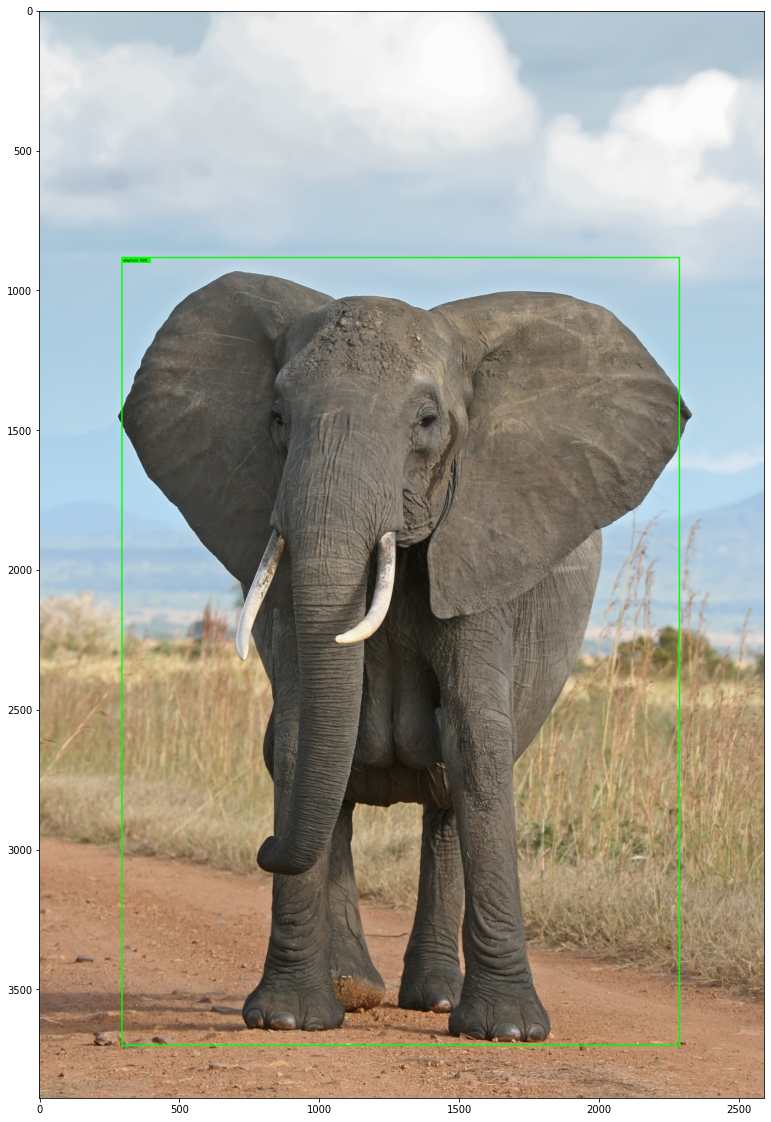

In [12]:
# Test the model on the elephant image.
image_np = np.array(Image.open('data/elephant.jpg'))
detections = detect_objects_on_image(image_np, model)
image_with_detections = draw_detections_on_image(image_np, detections, labels)
plt.figure(figsize=(20, 20))
plt.imshow(image_with_detections)

In [13]:
def plot(images, titles, subtitle=None, figsize=(8, 8)):
        
    cols = len(images)
    fig, axs = plt.subplots(1, cols, figsize=(cols * figsize[0], figsize[1]))
    if len(images) == 1:
        axs = [axs]
    if subtitle is not None:
        fig.suptitle(subtitle, fontsize=16)
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

In [14]:
def calculate_differencing(prev_f, f, vis=False):
    # Calculate the difference between the previous and the current frame.
    diff = cv2.absdiff(prev_f, f)
    if vis:
        plot([diff], ['diff'])
    return diff

# Granulacja obrazów

W następnym etapie zaimplementowaliśmy dwie funkcje do granulacji obrazów:
- `granulation` - obliczanie granulacji obrazu najprostszą metodą
- `granulation_gt` - obliczanie granulacji obrazu metodą *quad tree decomposition*

## Obliczanie granulacji najprostszą metodą

W tej metodzie obraz dzielimy na kwadraty o zadanym rozmiarze, a następnie dla każdego kwadratu obliczamy średnią wartość pikseli w nim zawartych.

In [15]:
def granulation(image, window_size=WINDOW_SIZE, vis=False):
    height, width = image.shape[:2]
    granules = np.zeros_like(image)
    for j in range(0, height, window_size):
        for i in range(0, width, window_size):
            granule = image[j : min(j+window_size, height), i:min(i+window_size, width)]
            granules[j : min(j+window_size, height), i:min(i+window_size, width)] = np.mean(granule, axis=(0, 1))

    if vis:
        plot([image, granules], ['Original', 'Granulated'], subtitle='Granulation')
        
    return granules

## Obliczanie granulacji metodą *quad tree decomposition*

W tej metodzie obraz dzielimy na 4 równe części, a następnie dla każdej z nich obliczamy średnią wartość koloru oraz błąd na podstawie histogramu pikseli w niej zawartych. Jeśli błąd w danej części jest większy niż zdefiniowany próg, to dzielimy tę część na kolejne cztery równe części, aż do osiągnięcia zdefiniowanej głębokości.

In [16]:
PADDING = 0
OUTPUT_SCALE = 1
ERROR_THRESHOLD = 5

def weighted_average(hist):
    """Returns the weighted color average and error from a hisogram of pixles"""
    total = sum(hist)
    value, error = 0, 0
    if total > 0:
        value = sum(i * x for i, x in enumerate(hist)) / total
        error = sum(x * (value - i) ** 2 for i, x in enumerate(hist)) / total
        error = error ** 0.5
    return value, error

def color_from_histogram(hist):
    """Returns the average rgb color from a given histogram of pixle color counts"""
    r, re = weighted_average(hist[:256])
    g, ge = weighted_average(hist[256:512])
    b, be = weighted_average(hist[512:768])
    e = re * 0.2989 + ge * 0.5870 + be * 0.1140
    return (int(r), int(g), int(b)), e

class QuadtreeNode(object):
    """Node for Quadtree that holds a subsection of an image and 
        information about that section"""

    def __init__(self, img, box, depth):
        self.box = box  # (left, top, right, bottom)
        self.depth = depth
        self.children = None  # tl, tr, bl, br
        self.leaf = False

        # Gets the nodes average color
        image = img.crop(box)
        self.width, self.height = image.size  # (width, height)
        hist = image.histogram()
        self.color, self.error = color_from_histogram(hist)  # (r, g, b), error
        
    def is_leaf(self):
            """Determins if a the node is a leaf"""
            return self.leaf
        
    def split(self, img):
        """Splits the given image section into four equal image boxes"""
        l, t, r, b = self.box
        lr = l + (r - l) / 2
        tb = t + (b - t) / 2
        tl = QuadtreeNode(img, (l, t, lr, tb), self.depth+1)
        tr = QuadtreeNode(img, (lr, t, r, tb), self.depth+1)
        bl = QuadtreeNode(img, (l, tb, lr, b), self.depth+1)
        br = QuadtreeNode(img, (lr, tb, r, b), self.depth+1)
        self.children = [tl, tr, bl, br]

class Quadtree(object):
    """Tree that has nodes with at most four child nodes that hold 
        sections of an image where there at most n leaf nodes where
        n is the number of pixles in the image"""

    def __init__(self, image, max_depth=1024):
        self.root = QuadtreeNode(image, image.getbbox(), 0)
        self.width, self.height = image.size
        self.max_depth = 0
        
        self._build_tree(image, self.root, max_depth)

    def _build_tree(self, image, node, max_depth):
        """Recursively adds nodes untill max_depth is reached or error is less than 5"""
        if (node.depth >= max_depth) or (node.error <= ERROR_THRESHOLD):
            if node.depth > self.max_depth:
                self.max_depth = node.depth
            node.leaf = True
            return
        
        node.split(image)
        for child in node.children:
            self._build_tree(image, child, max_depth)
        
    
    def get_leaf_nodes(self, depth):
        """Gets all the nodes on a given depth/level"""
        def get_leaf_nodes_recusion(tree, node, depth, func):
            """Recusivley gets leaf nodes based on whether a node is a leaf or the given depth is reached"""
            if node.leaf is True or node.depth == depth:
                func(node)
            elif node.children is not None:
                for child in node.children:
                    get_leaf_nodes_recusion(tree, child, depth, func)

            if depth > tree.max_depth:
                raise ValueError('A depth larger than the trees depth was given')

        leaf_nodes = []
        get_leaf_nodes_recusion(self, self.root, depth, leaf_nodes.append)
        return leaf_nodes
        

    def _create_image_from_depth(self, depth):
        """Creates a Pillow image object from a given level/depth of the tree"""
        m = OUTPUT_SCALE
        dx, dy = (PADDING, PADDING) # padding for each image section
        image = Image.new('RGB', (int(self.width * m + dx), int(self.height * m + dy)))
        draw = ImageDraw.Draw(image)
        draw.rectangle((0, 0, self.width * m + dx, self.height * m + dy), (0, 0, 0))
        granules = []
        leaf_nodes = self.get_leaf_nodes(depth)
        for node in leaf_nodes:
            l, t, r, b = node.box
            box = (l * m + dx, t * m + dy, r * m - 1, b * m - 1)
            granule_size = (int((r-l) * m), int((b-t) * m))  # Calculate the size of the granule
            granule = Image.new('RGB', granule_size, node.color)  # Create a new image with the size and color of the granule
            granule = np.array(granule)
            granules.append(granule)
            draw.rectangle(box, node.color)
        return image, granules

    def render_at_depth(self, depth=0):
        """Renders the image of a given depth/level"""
        if depth > self.max_depth:
            raise ValueError('A depth larger than the trees depth was given')

        image, granules = self._create_image_from_depth(depth)
        return image, granules
        # image.show()

    def create_gif(self, file_name, duration=1000, loop=0):
        """Creates a gif at the given filename from each level of the tree"""
        images = []
        end_product_image = self._create_image_from_depth(self.max_depth)
        for i in range(self.max_depth):
            image = self._create_image_from_depth(i)
            images.append(image)
        # Add extra final produc images to allow for seeing result longer
        for _ in range(4):
            images.append(end_product_image)
        # Save the images as a gif using Pillow
        images[0].save(
            file_name, 
            save_all=True, 
            append_images=images[1:],
            duration=duration, loop=loop)

In [17]:
def granulation_gt(frame, visual=False, max_depth=6):
    frame_pil = Image.fromarray(frame)
    tree = Quadtree(frame_pil, max_depth=max_depth)
    image, granules = tree.render_at_depth(max_depth)
    image = np.array(image)
    if visual:
        plot([frame, image], ['Original', 'Granulated'], subtitle='Granulation')
    return image, granules

Przykład użycia:

Text(0.5, 1.0, 'Granulated')

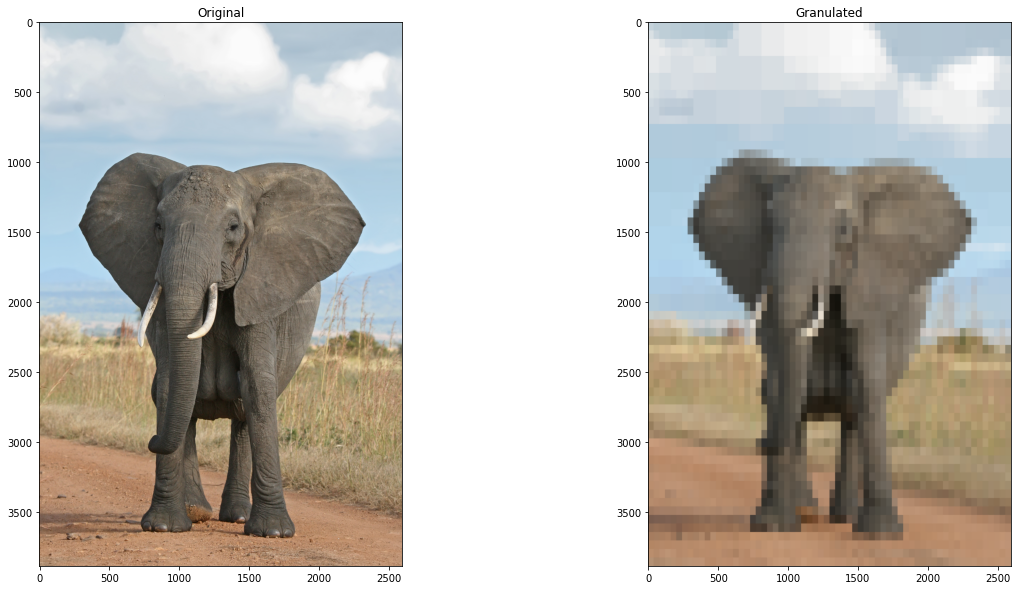

In [18]:
img = cv2.cvtColor(cv2.imread('data/elephant.jpg'), cv2.COLOR_BGR2RGB)
img_granulated, granules = granulation_gt(img)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[0].set_title('Original')
axs[1].imshow(img_granulated)
axs[1].set_title('Granulated')

# Detekcja ruchomych obiektów

W ostatnim etapie chcieliśmy połączyć granulację obrazów z detekcją ruchu. Podczas eksperymentów zwróciliśmy uwagę na liczne problematyczne aspekty implementacyjne, które nie zostały poruszone w artykule.

Musimy zatemm stwierdzić, że nasze prace nie przyniosły oczekiwanych rezultatów, a granulacja nie spełniła swojej roli w procesie detekcji ruchu z wykorzystaniem głębokiego uczenia. 

## Dlaczego granulacja nie spełnia swojej roli w badanym przypadku?

Analizowana przez nas publikacja przedstawiała podejście, które opierało się na wykorzystaniu sieci neuronowej używającej granulacji obrazów oraz, docelowo, transfer-learningu.
Przestawiona przez autorów warstwa granulacyjna miała za zadanie zastąpić (lub poprzedzać) warstwę konwolucyjną w sieci SSD, co miało pozwolić na wykorzystanie granulacji w procesie detekcji obiektów.

Niestety, w naszym przypadku, zastosowanie granulacji nie przyniosło oczekiwanych rezultatów. Z naszych eksperymentów wyciągamy następujące wnioski:

- **Brak możliwośći wykorzystania transfer-learningu** - Wynika to z faktu, że podstawy konwolucyjne sieci SSD zostały wytrenowane na obrazach, które nie były granulowane. W związku z tym, sieć nie jest w stanie wykryć obiektów na granulowanych obrazach. Możliwe jest oczywiście przetrenowanie sieci na granulowanych obrazach, jednak wymagałoby to ogromnej ilości czasu i zasobów, a przede wszystkim prawdoopodobnie nie przyniosłoby oczekiwanych rezultatów. 

- **Granulacja powoduje utratę szczegółowości informacji** - Jedną z wad granulacji przedstawia poniższy przykład. Po lewej mamy obraz oryginalny, przeskalowany w dół, a po prawej obraz granulowany. Jak widać, granulacja powoduje utratę informacji  (np. nie widzimy oka słonia), co w przypadku sieci neuronowych może prowadzić do znacznych problemów z uczeniem, a nauczone na granulowanych obrazach modele mogą być mniej dokładne.

- **Przekazywanie nieregularnych granulek do sieci neuronowych** - Warto również zauważyć, że granulek o nieregularnych kształtach, nie jesteśmy w stanie przekazać konwolucyjnym warstwom w sieci neuronowej (możliwe jest jedynie przekazanie kwadratów, prostokątów, itp. jako odpowiedniki pikseli). Wykorzystanie nieregularnych granulek miało wpłynąć na zmniejszenie ilości obliczeń, ale okazuje się być to prawdopodobnie niemożliwe.

- **Brak różniczkowalności** - Należy również dodać, że granulacja jest operacją nieliniową, co sprawia, że nie jest ona różniczkowalna. W związku z tym, nie jest możliwe stworzenie trenowalnych warstw granulacyjnych w sieciach neuronowych.

$$g(a) + g(b) \neq g(a+b)$$

In [19]:
d = recognition_of_moving_objects(img)
d_g = recognition_of_moving_objects(img_granulated)

In [20]:
factor = 0.05
img_resized = cv2.resize(img, (int(img.shape[1]* factor), int(img.shape[0]* factor)))
d_resized = recognition_of_moving_objects(img_resized)
img_resized_granuled, granules_resized = granulation_gt(img, max_depth=7)
img_resized_granuled = cv2.resize(img_resized_granuled, (int(img_resized_granuled.shape[1]* factor), int(img_resized_granuled.shape[0]* factor)))
d_resized_granuled = recognition_of_moving_objects(img_resized_granuled)

Text(0.5, 1.0, 'Granulated')

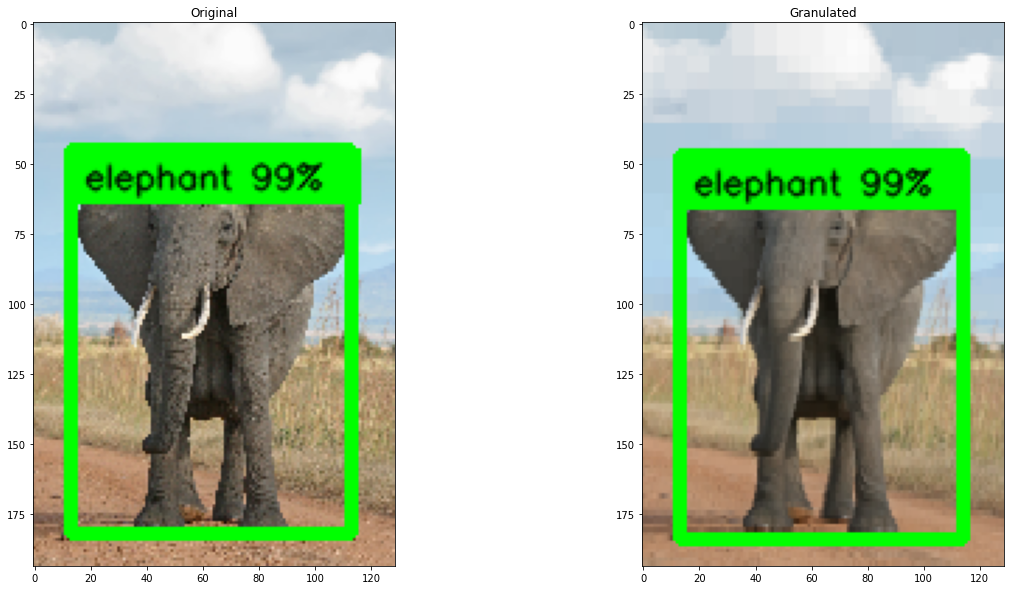

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(draw_detections_on_image(img_resized, d_resized, labels))
axs[0].set_title('Original')
axs[1].imshow(draw_detections_on_image(img_resized_granuled, d_resized_granuled, labels))
axs[1].set_title('Granulated')

## Alternatywne podejście z wykorzystaniem granulacji

Aby wykorzystać granulację w procesie śledzenia obiektów, zdecydowaliśmy się na zastosowanie granulacji obrazów w celu wykrycia ruchu na obrazie. Granulacja obrazów pozwala na zredukowanie ilości informacji w obrazie, co pozwala na szybsze przetwarzanie obrazu. 

Zaimplementowaliśmy następujący algorytm:

- obliczamy granulację ramki obecnej,
- obliczamy różnicę między granulacją ramki obecnej a granulacją ramki poprzedniej,
- wykrywamy ruch na obrazie na podstawie różnicy granulacji,
- obszary, w których wykryto ruch, są wycinane z obecnej ramki, a następnie są przekazywane do sieci neuronowej, która dokona klasyfikacji obiektów

Podejście to pozwala na zwiększenie szybkości przetwarzania obrazu, a także na zredukowanie ilości informacji przekazywanej do sieci neuronowej, co pozwala na zwiększenie szybkości działania sieci oraz poprawę jakości klasyfikacji.

In [22]:
def load_roi(file_path):
    with open(file_path, 'r') as f:
        line = f.readline()
        roi_start, roi_end = line.split()
        roi_start = int(roi_start)
        roi_end = int(roi_end)
    return roi_start, roi_end

In [23]:
roi_start, roi_end = load_roi('data/pedestrian/temporalROI.txt')

roi_start_hw, roi_end_hw = load_roi('data/highway/temporalROI.txt')

In [24]:
PATH = 'data/pedestrian'

f1 = cv2.imread(f'{PATH}/input/in%06d.jpg' % (roi_start+30))
f2 = cv2.imread(f'{PATH}/input/in%06d.jpg' % (roi_start+30+1))

In [25]:
def extract_moving_objects(f2, g1, g2, tresh=10, vis=False, pad_factor=0.2):

    d = calculate_differencing(g1, g2, vis=vis)

    m = cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
    m = (m>tresh).astype(np.uint8)
    m = cv2.dilate(m.astype(np.uint8), np.ones((5,5), np.uint8), iterations=4)
    m = cv2.erode(m, np.ones((5,5), np.uint8), iterations=2)
    if vis: 
        plt.figure()
        plt.imshow(m)

    c, h = cv2.findContours(m, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    f1_out = f2.copy()

    detections = []

    for i in range(len(c)):
        x,y,w,h = cv2.boundingRect(c[i])
        y_pad = int(h*pad_factor)
        x_pad = int(w*pad_factor)
        x = max(x-x_pad,0)
        y = max(y-y_pad,0)
        w = min(w+2*x_pad, f2.shape[1]-x)
        h = min(h+2*y_pad, f2.shape[0]-y)

        if vis: 
            plt.figure()
            plt.imshow(cv2.rectangle(f2.copy(), (x,y), (x+w,y+h), (0,255,0), 2))

        s = f2[y:y+h, x:x+w]
        if vis: 
            plt.figure()
            plt.imshow(s)

        r = recognition_of_moving_objects(s)
        for j, db in enumerate(r['detection_boxes']):
            y1, x1, y2, x2 = db
            y1, x1, y2, x2 = int(y1*h), int(x1*w), int(y2*h), int(x2*w)
            y1, x1, y2, x2 = y+y1, x+x1, y+y2, x+x2
            y1, x1, y2, x2 = y1/f2.shape[0], x1/f2.shape[1], y2/f2.shape[0], x2/f2.shape[1]
            r['detection_boxes'][j] = [y1, x1, y2, x2]
        draw_detections_on_image(f1_out, r, labels)
        if vis: 
            plt.figure()
            plt.imshow(f1_out)
        detections.append(r)
    
    return f1_out, detections

In [26]:
g1, _ = granulation_gt(f1)
g2, _ = granulation_gt(f2)

Poniższa komórka pokazuje kolejne etapy działania algorytmu.

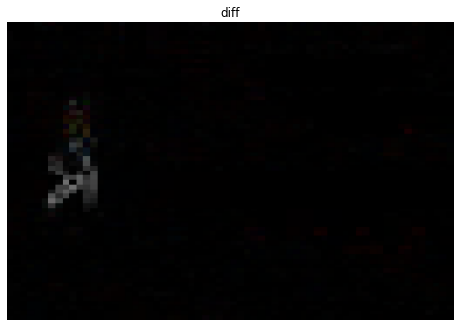

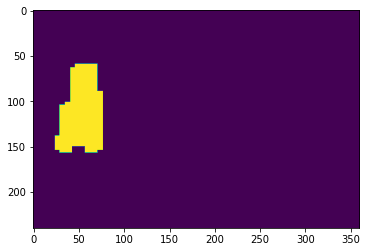

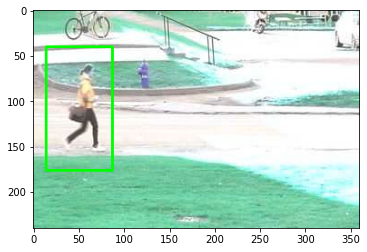

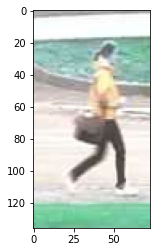

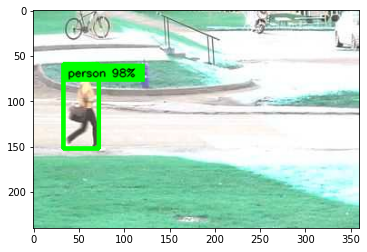

In [27]:
f1_out, dets = extract_moving_objects(f2, g1, g2, tresh=10, vis=True)

Następnie zaimplementowaliśmy funkcję `track`, która wykorzystuje granulację obrazów do detekcji ruchu na obrazie, 
oraz `track_base`, która nie wykorzystuje granulacji obrazów.

In [28]:
def track_base(path, roi_start=roi_start, roi_end=roi_end):
            
    init_frame = True

    for i in range(roi_start, roi_end, 1):
        frame = cv2.imread(f'{path}/input/in%06d.jpg' % i)

        if init_frame:
            init_frame = False
            continue

        frame_out = frame.copy()
        r = recognition_of_moving_objects(frame)
        draw_detections_on_image(frame_out, r, labels)

        cv2.imshow('frame', frame_out)
        if cv2.waitKey(10) == ord('q'):
            cv2.destroyAllWindows()
            break

    cv2.destroyAllWindows()


In [29]:
def track(path, granulate=True, roi_start=roi_start, roi_end=roi_end, tresh=10, pad_factor=0.2):
            
    init_frame = True
    g, g_prev = None, None

    modifier = granulation if granulate else lambda x: x

    for i in range(roi_start, roi_end, 1):
        frame = cv2.imread(f'{path}/input/in%06d.jpg' % i)

        g = modifier(frame)

        if init_frame:
            init_frame = False
            g_prev = g
            continue

        frame_out, _ = extract_moving_objects(
            frame,
            g_prev,
            g,
            tresh=tresh, 
            vis=False,
            pad_factor=pad_factor
        )

        cv2.imshow('frame', frame_out)
        if cv2.waitKey(10) == ord('q'):
            cv2.destroyAllWindows()
            break

        g_prev = g

    cv2.destroyAllWindows()


Przykładowe wyniki

In [36]:
track_base('data/pedestrian', roi_start=roi_start, roi_end=roi_end) # tracking bez granulacji, z SSD analizującym cały obraz

In [37]:
track('data/pedestrian', roi_start=roi_start, roi_end=roi_end) # tracking z granulacją, z SSD analizującym podobszary, w których wykryto ruch

In [38]:
track_base('data/highway', roi_start=roi_start_hw, roi_end=roi_end_hw)

In [39]:
track('data/highway', roi_start=roi_start_hw, roi_end=roi_end_hw, pad_factor=1)

Klasyfikowane obiekty są wyświetlane na obrazie wraz z informacją o ich klasie oraz prawdopodobieństwie przynależności do danej klasy.
Na pierwszy rzut oka widać, że klasyfikacja obiektów jest poprawna, a granulacja pozwala na zwiększenie dokładności klasyfikacji.
Niestety, widzimy również, że wraz z pojawieniem się większej ilości obiektów na obrazie, FPS spada, co jest związane z koniecznością przetworzenia większej ilości obiektów przez sieć neuronową.

Jak widzimy, granulacja obrazów może być użyteczna w procesie detekcji obiektów, jednak nie w sposób, w jaki zostało to zaprezentowane w analizowanej publikacji.

## Podsumowanie
Nasze eksperymenty z połączeniem granulacji obrazów i detekcji ruchu przy użyciu głębokiego uczenia nie przyniosły oczekiwanych rezultatów. Przedstawione w analizowanej publikacji podejście, które zakładało zastosowanie granulacji przed lub zamiast warstwy konwolucyjnej w sieci SSD, okazało się problematyczne. Kluczowe wnioski z naszych badań to:

- **Problemy z transfer-learningiem**: Sieci SSD wytrenowane na standardowych obrazach nie potrafią efektywnie działać na obrazach granulowanych. Przetrenowanie sieci na granulowanych obrazach wymagałoby znacznych zasobów i czasu, a uzyskane wyniki prawdopodobnie byłyby niezadowalające.
- **Utrata szczegółowości**: Granulacja powoduje utratę istotnych szczegółów na obrazach, co utrudnia naukę i dokładność sieci neuronowych. Przykładem jest niewidoczne oko słonia na granulowanym obrazie.
- **Problemy z nieregularnymi granulkami**: Nieregularne granulki nie mogą być łatwo przetwarzane przez warstwy konwolucyjne, co ogranicza możliwości optymalizacji obliczeniowej.
- **Brak różniczkowalności**: Granulacja jest operacją nieliniową i nieróżniczkowalną, co uniemożliwia tworzenie trenowalnych warstw granulacyjnych w sieciach neuronowych.

### Alternatywne podejście
Podjęliśmy próbę zastosowania granulacji do wykrywania ruchu na obrazach w inny sposób. Nasze podejście polegało na:

- Obliczaniu granulacji obecnej i poprzedniej ramki,
- Porównywaniu granulacji między ramkami w celu wykrycia ruchu,
- Przekazywaniu wykrytych obszarów ruchu do sieci neuronowej do klasyfikacji obiektów.

To podejście okazało się skuteczniejsze, pozwalając na szybsze przetwarzanie obrazów i zwiększenie dokładności klasyfikacji. Jednak wraz ze wzrostem liczby obiektów na obrazie, wydajność (FPS) spadała, co wynikało z konieczności przetwarzania większej liczby obiektów przez sieć neuronową.

## Wnioski
Granulacja obrazów może być przydatna w procesie detekcji ruchu, jednak nie w formie zaprezentowanej w analizowanej publikacji. Alternatywne podejście, które łączy granulację z wykrywaniem ruchu, a następnie klasyfikacją obiektów, pokazuje pewne korzyści, ale również ujawnia ograniczenia związane z wydajnością przy dużej liczbie obiektów.